# Neural Field

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/NeuralField.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/NeuralField.ipynb)

In [1]:
#!pip install ANNarchy

This notebook demonstrates a simple rate-coded model using [Neural Fields](http://www.scholarpedia.org/article/Neural_fields). It consists of two 2D populations `inp` and `pop`, with one-to-one connections between `inp` and `pop`, and Difference-of-Gaussians (DoG) lateral connections within `pop`.

It is is based on the following paper:

> Nicolas P. Rougier and Julien Vitay (2005). Emergence of attention within a neural population. *Neural Networks* 19(5). [doi:10.1016/j.neunet.2005.04.004](https://doi.org/10.1016/j.neunet.2005.04.004) 

## Model overview

Each population consists of N\*N neurons, with N=20. The `inp` population is solely used to represent inputs for `pop`. 
The `pop` population implements a discretized neural field, with neurons following the ODE:

$$\tau \frac{d r_i(t)}{dt} + r_i(t) = r^\text{input}_i(t) + \sum_{j=1}^{N} w_{j, i} \cdot r_j(t) + \eta(t)$$

where $r_i(t)$ is the neuron's firing rate, $\tau$ a time constant and $w_{j, i}$ the weight
value (synaptic efficiency) of the synapse between the neurons j and i. $\eta(t)$ is an additive
noise uniformly taken in $[-0.5, 0.5]$.
$f()$ is a semi-linear function, ensuring the firing rate is bounded between 0 and 1.

Each neuron in `pop` takes inputs from the neuron of `inp` which has the same position, leading to a `one_to_one` connection pattern.

The lateral connections within `pop` follow a difference-of-Gaussians (`dog`) connection pattern, with the connection weights $w_{i,j}$ depending on the normalized euclidian distance between the neurons in the N*N population:

$$w_{j, i} = A^+ \cdot \exp(-\frac{1}{2}\frac{d(i, j)^2}{\sigma_+^2}) -  A^- \cdot \exp(-\frac{1}{2}\frac{d(i, j)^2}{\sigma_-^2})$$

If i and j have coordinates $(x_i, y_i)$ and $(x_j, y_j)$ in the N*N space, the distance between them is computed as:

$$d(i, j)^2 = (\frac{x_i - x_j}{N})^2 + (\frac{y_i - y_j}{N})^2$$

Inputs are given to the network by changing the firing rate of `inp` neurons.

## Importing ANNarchy

We first start by importing the numpy and ANNarchy libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import ANNarchy as ann

ANNarchy 4.8 (4.8.3) on linux (posix).


The `setup()` method allows to configure ANNarchy to run in different modes, such as chosing the parallel framework (omp or cuda), setting the simulation step `dt`, the numerical method `method` or the `seed` of the random number generators.

## Defining the neuron

In [3]:
NeuralFieldNeuron = ann.Neuron(

    parameters = dict(tau = 10.0),
    
    equations = ann.variable(
        'tau * dr/dt + r = sum(exc) + sum(inh) + Uniform(-0.5, 0.5)', min=0.0, max=1.0
    )
)

The NeuralField neuron is governed by an ODE and considers inputs from other neurons. It has a non-linear
activation function, which is linear when the firing rate is between 0.0 and 1.0, and constant otherwise.

`tau` is a population-wise parameter, whose value will be the same for all neurons of the population. 

`r` is the firing rate of he neuron, whose dynamics are governed by a first-order linear ODE integrating the sums of excitatory and inhibitory inputs with noise. 

`sum(exc)` retrieves the weighted sum of pre-synaptic firing rates for the synapses having the connection type `exc`, here the one\_to\_one connections between `inp` and `pop`. `sum(inh)` does the same for `inh` type connections, here the lateral connections within `pop`.

The firing rate is restricted to the range [0, 1] by setting the `min` and `max` accordingly in the variable definition. This means that after evaluating the ODE and getting a new value for `r`, its value will be clamped if it outside these values. One can define both `min` and `max`, only one of them, or none.  

## Creating the populations

The two populations have a geometry of (20, 20), therefore 400 neurons
each. They are created simply by instantiating the `Population` class:

In [4]:
N = 20
inp = ann.InputArray(geometry = (N, N), name='Input')
pop = ann.Population(geometry = (N, N), neuron = NeuralFieldNeuron, name='Focus')

The populations can be assigned a unique name (here 'Input' and
'Focus') in order to be be able to retrieve them if the references
`inp` and `focus` are lost. They are given a 2D geometry and
associated to the corresponding `Neuron` instance.

## Creating the projections

The first projection is a one-to-one projection from Input to Focus with
the type 'exc'. This connection pattern pattern is possible because the
two populations have the same geometry. The weights are initialized to
1.0, and this value will not change with time (no learning), so it is
not necessary to define a synapse type:

In [5]:
ff = ann.Projection(pre=inp, post=pop, target='exc')
ff.connect_one_to_one(weights=1.0, delays = 20.0)

The references to the pre- and post-synaptic population (or their
names), as well as the target type, are passed to the constructor of
`Projection`. The connector method `connect_one_to_one()` is immediately
applied to the Projection, defining how many synapses will be created.
The weights are initialized uniformly to 1.0.

The second projection is a difference of gaussians (DoG) for the lateral
connections within `pop`. The connector method is already provided by
ANNarchy, so there is nothing more to do than to call it with the right
parameters:

In [6]:
lat = ann.Projection(pre=pop, post=pop, target='inh')
lat.connect_dog(amp_pos=0.2, sigma_pos=0.1, amp_neg=0.1, sigma_neg=0.7)

We set two monitors recording the firing rate of the two populations:

In [7]:
m = ann.Monitor(inp, 'r')
n = ann.Monitor(pop, 'r')

## Compiling the network and simulating

Once the populations and projections are created, the network is ready to be generated, compiled and simulated. Compilation is simply done by calling `compile()`:

In [8]:
ann.compile()

Compiling ...  OK 


This generates optimized C++ code from the neurons' definition and network structure, compiles it with gcc/clang and instantiates all objects, particularly the synapses. If some errors were made in the neuron definition, they will be signaled at this point.

**Hint:** The call to `compile()` is mandatory in any script. After it is called, populations and projections can not be added anymore.

Once the compilation is successful, the network can be simulated by
calling `simulate()`. As no input has been fed into the network yet, calling `simulate()` now
won't lead to anything interesting. The next step is to clamp inputs into the input population's baseline.

## Setting inputs

### Tight loop

In this example, we use a moving bubble of activity rotating along a circle in the 20*20 input space in 1 second (i.e. 1000 steps). The simplest way of setting such inputs is to access population attributes (namely `inp.r`) in a tight loop in Python:

In [9]:
def gaussian(angle):
    "Unnormalized Gaussian at the specified angle."
    # 20*20 matrices with XY coordinates
    xx, yy = np.meshgrid(np.linspace(0, N-1, N), np.linspace(0, N-1, N))

    # Compute the center of the bubble
    cx = N / 2. * ( 1.0 + 0.5 * np.cos(2.0 * np.pi * angle ) )
    cy = N / 2. * ( 1.0 + 0.5 * np.sin(2.0 * np.pi * angle ) )

    # Gaussian
    bubble = np.exp(-((xx-cx)**2 + (yy-cy)**2)/8.0)
    return bubble

# Main loop
T = 1000
angle = 0.0
for t in range(T):

    # Update the angle
    angle += 1.0/T
    
    # Clamp the firing rate of inp with the Gaussian and some noise
    inp.r = gaussian(angle) + np.random.uniform(-0.5, 0.5, (N, N))
    
    # Simulate for one step = 1 ms
    ann.step()  

`angle` represents the angle made by the bubble with respect to the center of the input population. At each iteration of the simulation (i.e. every millisecond of simulation), the bubble is slightly rotated (`angle` is incremented) so as to make a complete revolution in 1 seconds (1000 steps). 

A Gaussian function (in the form of the Numpy array returned by the `gaussian()` methpd) is then clamped into the activity of `inp`. Some uniform noise is then added.

Last, a single simulation step is performed using `step()`. `step()` is equivalent to `simulate(dt)`, although a little bit faster as it does not check anything.

Let's plot the firing rates of the two populations at the end of the simulation:

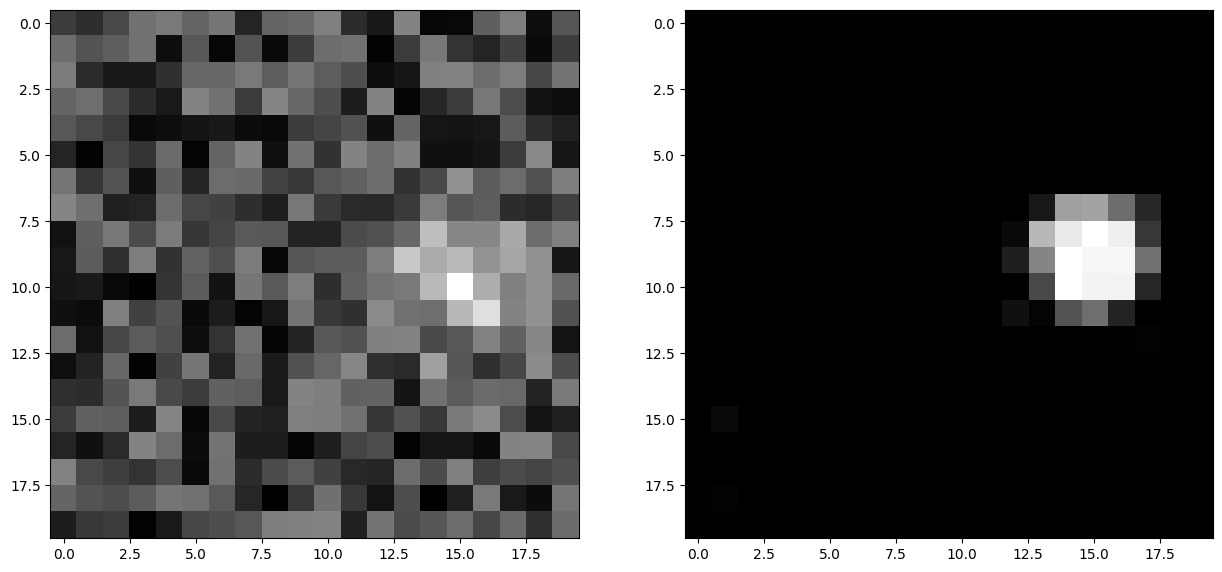

In [10]:
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(inp.r, interpolation='nearest', cmap=plt.cm.gray)
plt.subplot(122)
plt.imshow(pop.r, interpolation='nearest', cmap=plt.cm.gray)
plt.show()

We see a noisy bubble of activity in `inp` and a clean one in `pop`, demonstrating the noise-filtering capacities of neural fields. 

Let's retrieve the data recorded by the monitors, and use Matplotlib animations to show how the firing rates changed during the simulation (other methods are possible):

In [11]:
inp_data = m.get('r')
pop_data = n.get('r')

In [12]:
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)

im1 = ax1.imshow(inp.r, interpolation='nearest', cmap=plt.cm.gray)
im2 = ax2.imshow(pop.r, interpolation='nearest', cmap=plt.cm.gray)

def drawframe(n):
    im1.set_data(inp_data[n].reshape((N, N)))
    im2.set_data(pop_data[n].reshape((N, N)))    
    return (im1, im2)

anim = animation.FuncAnimation(fig, drawframe, frames=T, interval=2, blit=True)
plt.close()
HTML(anim.to_html5_video())

Everything works as expected. However, the simulation is actually quite slow (even if you do not notice it here), as Python is bad at tight loops like this one. For longer simulations, the overhead of python might become too damaging.

### TimedArray

A much more efficient variant is to precompute the input rates and store them in an array that will be iteratively read by the ``TimedArray``object. This is a new population that unfortunately cannot be added to the network anymore, as we have already compiled it. Let's clear the network and redefine everything, replacing the `InputArray` with a `TimedArray` of the same shape:

In [13]:
ann.clear()

NeuralFieldNeuron = ann.Neuron(
    parameters="tau = 10.0 : population",
    equations="tau * dr/dt + r = sum(exc) + sum(inh) + Uniform(-0.5, 0.5) : min=0.0, max=1.0")

N = 20
inp = ann.TimedArray(geometry = (N, N), name='Input')
pop = ann.Population(geometry = (N, N), neuron = NeuralFieldNeuron, name='Focus')

ff = ann.Projection(pre=inp, post=pop, target='exc')
ff.connect_one_to_one(weights=1.0, delays = 20.0)

lat = ann.Projection(pre=pop, post=pop, target='inh')
lat.connect_dog(amp_pos=0.2, sigma_pos=0.1, amp_neg=0.1, sigma_neg=0.7)

m = ann.Monitor(inp, 'r')
n = ann.Monitor(pop, 'r')

ann.compile()

Compiling ...  OK 


We now create a numpy array of shape $(T, N, N)$ where $T$ is the duration of the simulation (1000 steps) and $N$ the dimension of the neural field. We make sure to add noise to the inputs.

We then set the `rates` parameter of the `TimedArray`to that array by using `update()`. At each step of the simulation, the timed array will "read" a new input activity in that array and store it as `r`. We simply need to call `simulate()`for the whole duration of the simulation, instead of using a slow tight loop in Python.

In [14]:
def gaussian(angle):
    "Unnormalized Gaussian at the specified angle."
    # 20*20 matrices with XY coordinates
    xx, yy = np.meshgrid(np.linspace(0, N-1, N), np.linspace(0, N-1, N))

    # Compute the center of the bubble
    cx = N / 2. * ( 1.0 + 0.5 * np.cos(2.0 * np.pi * angle ) )
    cy = N / 2. * ( 1.0 + 0.5 * np.sin(2.0 * np.pi * angle ) )

    # Gaussian
    bubble = np.exp(-((xx-cx)**2 + (yy-cy)**2)/8.0)
    return bubble

# Precompute the angles for 1000 steps = 1 cycle
T = 1000
angles = np.linspace(0, 1, T)

# Accumulate the 1000 inputs with time as the first dimension
input_rates = np.array([gaussian(angle) + np.random.uniform(-0.5, 0.5, (N, N)) for angle in angles])

# Set it as the rates argument of the input population
inp.update(input_rates)

# Simulate for 1 second
ann.simulate(T)

# Retrieve the recordings
inp_data = m.get('r')
pop_data = n.get('r')

In [15]:
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)

im1 = ax1.imshow(inp.r, interpolation='nearest', cmap=plt.cm.gray)
im2 = ax2.imshow(pop.r, interpolation='nearest', cmap=plt.cm.gray)

def drawframe(n):
    im1.set_data(inp_data[n].reshape((N, N)))
    im2.set_data(pop_data[n].reshape((N, N)))    
    return (im1, im2)

anim = animation.FuncAnimation(fig, drawframe, frames=T, interval=2, blit=True)
plt.close()
HTML(anim.to_html5_video())